In [1]:
#Import 
import numpy as np
from scipy.special import inv_boxcox
from statsmodels.tsa.seasonal import STL
from scipy import stats
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, acf, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,month_plot,quarter_plot
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns 
import itertools

In [2]:
#Specify start and end date
start_date = '1984-12-02'
end_date = '2021-05-31'
#Access data through api
Raw_data = data.DataReader('^GSPC', 'yahoo', start_date, end_date)
Raw_data.to_csv('./Raw_data.csv',index=True)

In [3]:
Raw_data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1984-12-03,163.580002,162.289993,163.580002,162.820007,95300000,162.820007
1984-12-04,163.910004,162.820007,162.820007,163.380005,81250000,163.380005
1984-12-05,163.399994,161.929993,163.380005,162.100006,88700000,162.100006
1984-12-06,163.110001,161.759995,162.100006,162.759995,96560000,162.759995
1984-12-07,163.309998,162.259995,162.759995,162.259995,81000000,162.259995
...,...,...,...,...,...,...
2021-05-24,4209.520020,4170.160156,4170.160156,4197.049805,2947400000,4197.049805
2021-05-25,4213.419922,4182.520020,4205.939941,4188.129883,3420870000,4188.129883
2021-05-26,4202.609863,4184.109863,4191.589844,4195.990234,3674490000,4195.990234


D:\Users\wfree\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
D:\Users\wfree\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

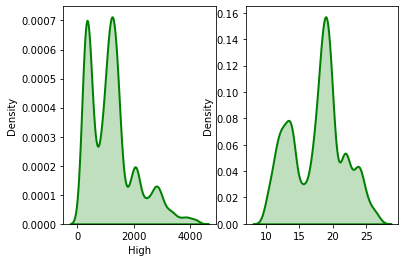

In [4]:
#Test with Feature 1
Feature1 = Raw_data.iloc[:,0]
fitted_data, fitted_lambda = stats.boxcox(Feature1)
fig, ax = plt.subplots(1, 2)
sns.distplot(Feature1, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Non-Normal", color ="green", ax = ax[0])
  
sns.distplot(fitted_data, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Normal", color ="green", ax = ax[1])
  

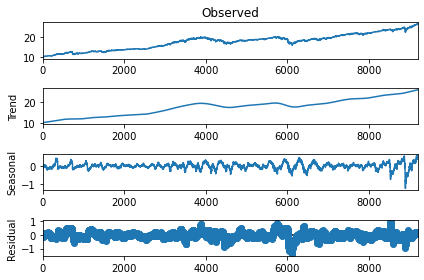

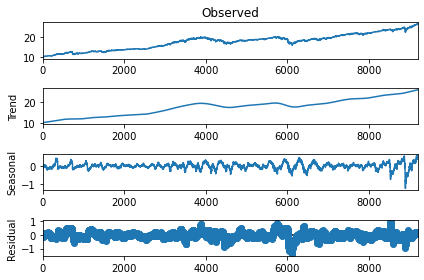

In [5]:
#Deseasonalize
from statsmodels.tsa.seasonal import STL
decom = STL(fitted_data, period=365)
Residuals = decom.fit()
Residuals.plot()

In [6]:
non_seasonal_data = fitted_data - Residuals.trend

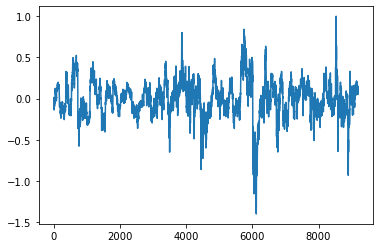

In [7]:
non_seasonal_data = fitted_data - Residuals.seasonal - Residuals.trend

plt.plot(non_seasonal_data)

In [8]:
#Augmented Dicky Fuller test for Stationarity 
from pandas import read_csv
from statsmodels.tsa.stattools import adfuller
DF_Results = adfuller(non_seasonal_data)
if DF_Results[1]<0.05:
    print("Data is Stationary")
else:
    print("Data is not Staitionary")

Data is Stationary


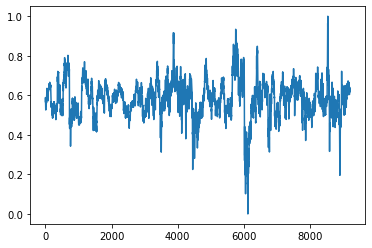

In [9]:
#Normalise
#Global Normalize
def Normalize(Input):
    return (Input - min(Input))/(max(Input)-min(Input))

Final_data = Normalize(non_seasonal_data)
plt.plot(Final_data)

In [10]:
#Global Normalize
def Normalize(Input):
    return (Input - min(Input))/(max(Input)-min(Input))

def Pre_Processing(DF):
    Processed_data= DF.copy()
    Trend_data = DF.copy()
    Seasonal_data = DF.copy()
    lambda_list = []
    min_max = []
    for i in range(len(DF.columns)):
        Col_name = DF.columns[i]
        Feature= DF[Col_name]
        print(Col_name)
        #Peform Box_Cox
        Fitted_data, Box_lambda = stats.boxcox(Feature)
        #Append Lambda to list incase its needed later
        lambda_list.append([Col_name,Box_lambda])
        
        
        #Decompose into trend and seasonality
        decom = STL(Fitted_data, period=365)
        Residuals = decom.fit()
        Trend_data[Col_name]= Residuals.trend
        Seasonal_data[Col_name]=Residuals.seasonal
        
        #Remove seasonality
        non_seasonal_data = Fitted_data - Residuals.trend
        min_max.append([Col_name,min(non_seasonal_data),max(non_seasonal_data)])
        #Normalize
        Normalized_non_seasonal = Normalize(non_seasonal_data)
        
        #Perform Augmented Dicky-Fuller
        DF_Results = adfuller(Normalized_non_seasonal)
        if DF_Results[1]<0.05:
            print("Data is Stationary")
        else:
            print("Data is not Staitionary")

        Processed_data[Col_name] = Normalized_non_seasonal
        
    return Processed_data, Trend_data, lambda_list , min_max       

In [11]:
Process_Data, Trend_data, Lambda_list, min_max = Pre_Processing(Raw_data)

High
Data is Stationary
Low
Data is Stationary
Open
Data is Stationary
Close
Data is Stationary
Volume
Data is Stationary
Adj Close
Data is Stationary


In [12]:
#Covert from normalised data back to Raw for Error
def Denormalize(DF, Trend_data, Lambda_list, min_max):
    #De-normalize data
    Un_normal = DF.copy()
    for i in range(len(DF.columns)):
        Feature = DF[min_max[i][0]]
        Original = Feature*(min_max[i][2]-min_max[i][1])+min_max[i][1]
        Un_normal[min_max[i][0]]=Original
    
    #Recompose trend and seasonal data
    Seasonal_data = Un_normal + Trend_data
    
    #Inverse box cox transformation 
    for i in range(len(Seasonal_data.columns)):
        Seasonal_data[Lambda_list[i][0]]= inv_boxcox(Seasonal_data[Lambda_list[i][0]],Lambda_list[i][1])
    
    return Seasonal_data

In [13]:
Original_data = Denormalize(Process_Data, Trend_data, Lambda_list, min_max)

In [14]:
Original_data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1984-12-03,163.580002,162.289993,163.580002,162.820007,9.530000e+07,162.820007
1984-12-04,163.910004,162.820007,162.820007,163.380005,8.125000e+07,163.380005
1984-12-05,163.399994,161.929993,163.380005,162.100006,8.870000e+07,162.100006
1984-12-06,163.110001,161.759995,162.100006,162.759995,9.656000e+07,162.759995
1984-12-07,163.309998,162.259995,162.759995,162.259995,8.100000e+07,162.259995
...,...,...,...,...,...,...
2021-05-24,4209.520020,4170.160156,4170.160156,4197.049805,2.947400e+09,4197.049805
2021-05-25,4213.419922,4182.520020,4205.939941,4188.129883,3.420870e+09,4188.129883
2021-05-26,4202.609863,4184.109863,4191.589844,4195.990234,3.674490e+09,4195.990234


In [15]:
#Split data
Training = Process_Data.iloc[:-399,:]
Val_Test = Process_Data.iloc[-400:,:]
Val = Val_Test.iloc[:-200,:]
Test = Val_Test.iloc[200:,:]
Process_Data.to_csv('./Processed.csv',index=True)
Training.to_csv('./Train.csv',index=True)
Val.to_csv('./Val.csv',index=True)
Test.to_csv('./Test.csv',index=True)

In [16]:
#Write Trend data, min_max and lambda
Trend_data.to_csv('./Trend.csv',index=True)

with open('Lambda.txt', 'w') as file:
    for i in Lambda_list:
        file.write('%s\n' % i)
        
with open('Min_max.txt', 'w') as file:
    for i in min_max:
        file.write('%s\n' % i)

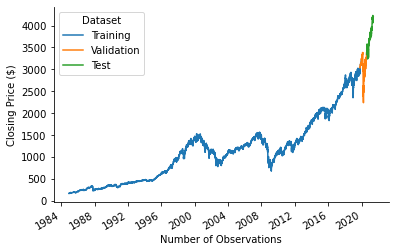

In [17]:
Fig, ax = plt.subplots()
Raw_data.iloc[:-365,3].plot()
Raw_data.iloc[-400:-200,3].plot()
Raw_data.iloc[-200:,3].plot()
plt.ylabel('Closing Price ($)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Number of Observations')
plt.legend(["Training","Validation", "Test"],title="Dataset")